<a href="https://colab.research.google.com/github/arisaghafari/blind_source_seperation/blob/master/DeepLearning_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this project, I experimented with several models.

### **Vision Transformer (ViT):**
My first approach was to use a Vision Transformer (ViT) model. I started by splitting the 32×32 grayscale input into small, non-overlapping patches, which were then converted into embeddings. These embeddings were processed through multiple transformer layers, utilizing multi-head self-attention and feed-forward networks. Afterward, the transformed features were reshaped back into a spatial grid and passed through a dual-decoder structure to reconstruct the original image.
**While this method incorporated an innovative design, it ultimately did not meet the performance requirements of the project.**

### **Hybrid TransUNet:**
To improve the results, I then explored a hybrid TransUNet model. This approach combined the strengths of both convolutional neural networks (CNNs) and transformers. The encoder, following a U-Net structure, extracted multi-scale features using CNN layers, while the bottleneck integrated transformer blocks to capture long-range dependencies. These transformer layers processed reshaped tokens, enriched with positional embeddings, to enhance feature learning. Finally, two parallel decoders worked together to reconstruct the source images.
**Although this model aimed to balance local and global contextual understanding, it ultimately did not achieve the desired performance.**

### **U-Net Model**

Finally, I implemented a U-Net architecture specifically designed to decompose composite images into their original components. The encoder progressively extracted hierarchical features using convolutional blocks, each followed by max pooling to reduce spatial dimensions while retaining essential information. To preserve fine-grained details, skip connections were used to bridge corresponding layers between the encoder and decoder.

At the network’s bottleneck, a convolutional block with 512 filters processed the most compressed representation of the input. From there, two parallel decoders upsampled the features, gradually restoring spatial resolution while integrating information from the encoder via skip connections. This design allowed the model to reconstruct the two separate images with high fidelity. **Among all the methods explored in this project, the U-Net model delivered the best performance, demonstrating its effectiveness in accurately recovering the original components from the composite input.**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist

import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 32, 32)


In [ ]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

In [ ]:
onegen = datagenerator(mnist_x_test,fashion_mnist_x_test,1)

In [ ]:
def show_images(x,y1,y2):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(x,cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1,cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2,cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

# **U_Net**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

#Convolution block
#2 consecutive convolution layer with BatchNormalization and ReLu Activation function
def conv_block(x, filters):
    x = layers.Conv2D(filters, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

# Encoder Block: Conv + MaxPooling
def encoder_block(x, filters):
    x = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

#Decoder Block: Upsampling + Skip Connection
def decoder_block(x, skip_features, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, filters)
    return x

# Build UNet model
def build_unet_decomposition(input_shape=(32, 32, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 128)
    s2, p2 = encoder_block(p1, 256)

    # Bottleneck
    b = conv_block(p2, 512)

    # Decoder for Image 1
    d1_3 = decoder_block(b, s2, 256)
    d1_4 = decoder_block(d1_3, s1, 128)
    output1 = layers.Conv2D(1, (1, 1), activation="sigmoid", name="image1_output")(d1_4)

    # Decoder for Image 2
    d2_3 = decoder_block(b, s2, 256)
    d2_4 = decoder_block(d2_3, s1, 128)
    output2 = layers.Conv2D(1, (1, 1), activation="sigmoid", name="image2_output")(d2_4)

    # Build Model
    model = Model(inputs, [output1, output2], name="U-Net_Decomposition")
    return model

# Create Model
UNET_model = build_unet_decomposition()

# Compile Model
UNET_model.compile(optimizer="adam",
              loss={"image1_output": "mse",
                    "image2_output": "mse"},
              metrics={"image1_output": ["accuracy"],
                       "image2_output": ["accuracy"]})

# Summary
UNET_model.summary()


Model: "U-Net_Decomposition"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 32, 32, 128)    │          1,280 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 32, 32, 128)    │            512 │ conv2d_28[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_28             │ (None, 32, 32, 128)    │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ activation_28[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_29    │ (None, 32, 32, 128)    │            512 │ conv2d_29[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_29             │ (None, 32, 32, 128)    │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 16, 16, 128)    │              0 │ activation_29[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 16, 16, 256)    │          1,024 │ conv2d_30[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_30             │ (None, 16, 16, 256)    │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 16, 16, 256)    │        590,080 │ activation_30[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, 16, 16, 256)    │          1,024 │ conv2d_31[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_31             │ (None, 16, 16, 256)    │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5      

 Total params: 10,324,354 (39.38 MB)

 Trainable params: 10,317,698 (39.36 MB)

 Non-trainable params: 6,656 (26.00 KB)

This model consists of approximately 10.3 million trainable parameters. A schematic diagram illustrating its architecture is provided in the following section.

### Visualizing neural network architectures

In [ ]:
!pip install visualkeras -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 15.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


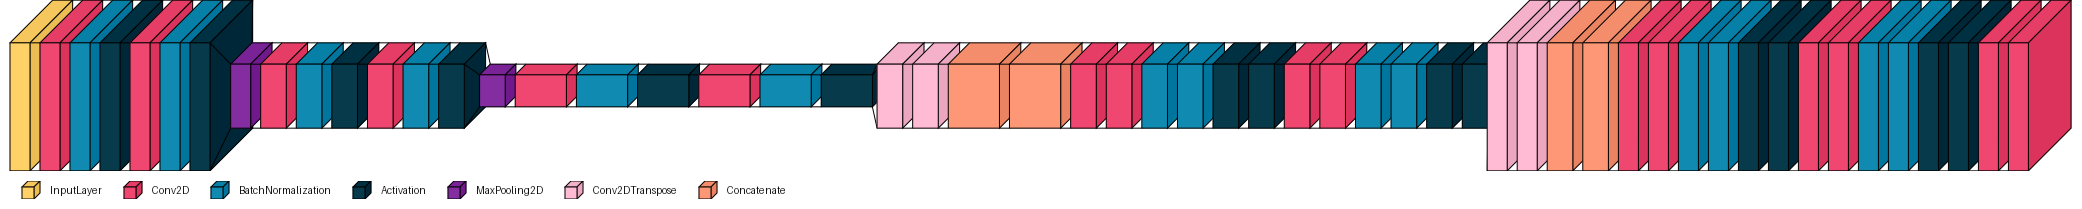

In [ ]:
import visualkeras

visualkeras.layered_view(UNET_model, legend=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Reduce learning rate when progress slows: If the validation loss doesn't improve for 4 epochs,
# the learning rate is reduced by 40% to help the model converge more effectively.
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.4,
    patience=4,
    min_lr=1e-6,
    min_delta=0.000001,
    mode="min",
    verbose=1
)

# Stop training if no improvement: If the validation loss doesn't improve for 8 epochs,
# training stops early to prevent overfitting and save time.
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=8,
    # restore_best_weights=True,
    min_delta=0.000001,
    verbose=1
)

# Save the best model: Keeps track of the model's best performance based on validation loss
# and saves the corresponding weights to avoid losing progress.
check_ponit = ModelCheckpoint(
    filepath='best_unet_model.weights.h5',
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True
)

In [ ]:
# Split into training and validation sets
mnist_X_tr, mnist_X_val, mnist_Y_tr, mnist_Y_val = train_test_split(mnist_x_train, mnist_y_train, test_size=0.2, random_state=42)
fash_X_tr, fash_X_val, fash_Y_tr, fash_Y_val = train_test_split(fashion_mnist_x_train, fashion_mnist_y_train, test_size=0.2, random_state=42)

In [ ]:
batch_size = 128

steps_per_epoch = int(np.ceil(mnist_X_tr.shape[0] / batch_size))
validation_steps = int(np.ceil(mnist_X_val.shape[0] / batch_size))

In [ ]:
# Fit the model for 200 epochs
# Using the EarlyStopping, ReduceLROnPlateau, and ModelCheckpoint callbacks
history = UNET_model.fit(
    datagenerator(mnist_X_tr,fash_X_tr, batch_size),
    steps_per_epoch=steps_per_epoch,
    validation_data=datagenerator(mnist_X_val, fash_X_val, batch_size),
    validation_steps=validation_steps,
    epochs=200,
    callbacks=[early_stopping, reduce_lr, check_ponit]
)

Epoch 1/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - image1_output_accuracy: 0.8468 - image1_output_loss: 0.0182 - image2_output_accuracy: 0.6152 - image2_output_loss: 0.0152 - loss: 0.0333 - val_image1_output_accuracy: 0.8542 - val_image1_output_loss: 0.0765 - val_image2_output_accuracy: 0.6190 - val_image2_output_loss: 0.0511 - val_loss: 0.1276 - learning_rate: 0.0010
Epoch 2/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - image1_output_accuracy: 0.8586 - image1_output_loss: 0.0020 - image2_output_accuracy: 0.6257 - image2_output_loss: 0.0021 - loss: 0.0041 - val_image1_output_accuracy: 0.8584 - val_image1_output_loss: 0.0019 - val_image2_output_accuracy: 0.6253 - val_image2_output_loss: 0.0045 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 3/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - image1_output_accuracy: 0.8583 - image1_output_loss: 0.0014 - image2_output_accuracy: 0.6246 - image2_output_loss: 0.0016 - loss: 0.0030 - val_image1_output_accuracy: 0.8593 - val_image1_ou

### Visualizing training loss and validation loss

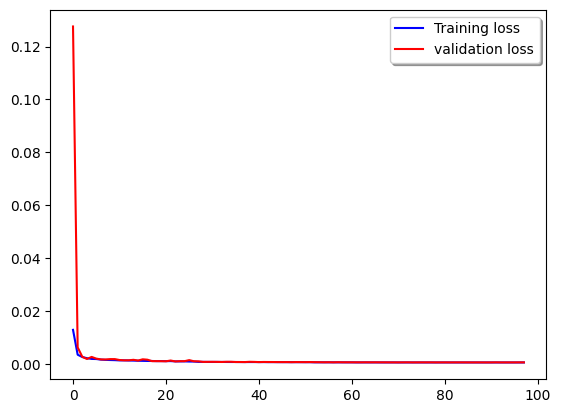

In [ ]:

plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
legend = plt.legend(loc='best', shadow=True)

plt.show()

The graph shows the training (blue) and validation (red) loss decreasing and leveling off at similar values, indicating the model is learning well without overfitting. This suggests the model performs consistently on both the training and validation data, showing good generalization and effective learning.

# Model evalaution

Let us define the test generator.

In [ ]:
#test generator
testgen = datagenerator(mnist_x_test,fashion_mnist_x_test,5000)

eval_samples_x, (eval_samples_y1, eval_sample2) = next(testgen)

In [ ]:
# Returning the output of the UNet model for the input x
def Umodel_pr(x):
  pred1, pred2 = UNET_model.predict(x)
  return(np.squeeze(pred1),np.squeeze(pred2))

In [ ]:
def eval_model(model):

  x, (y1,y2) = next(testgen)
  pred1,pred2 = model(x)
  return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2) / 2)

In [ ]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(Umodel_pr))
print("mse = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
mse =  0.0005563156897254335
standard deviation =  7.039705877823854e-06
